In [1]:
# ==========================================
# Part 1: 套件安裝與設定
# ==========================================

# 安裝必要套件
!pip install pycocotools
!pip install albumentations
!pip install efficientnet-pytorch
!pip install timm
!pip install sklearn
!pip install matplotlib seaborn

# 匯入基本套件
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import requests
from urllib.parse import urlparse
import zipfile
from tqdm import tqdm
import random

# 深度學習套件
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import timm

# 評估套件
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# COCO API
from pycocotools.coco import COCO

# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用裝置: {device}")

# 設定隨機種子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

print("套件安裝與設定完成！")

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=50da8a73912724b8074137cafd1e53bfd46e4e02ec5c354af3a170bf06910908
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet-pytorch
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
使用裝置: cuda
套件安裝與設定完成！


In [16]:
# ==========================================
# Part 2: 資料下載與處理
# ==========================================

# 定義目標類別
TARGET_CATEGORIES = ['bear', 'elephant', 'airplane', 'train']
CATEGORY_TO_ID = {'bear': 23, 'elephant': 21, 'airplane': 5, 'train': 7}  # COCO category IDs
ID_TO_LABEL = {0: 'bear', 1: 'elephant', 2: 'airplane', 3: 'train'}

# 下載COCO annotations
def download_coco_annotations():
    """下載COCO annotations檔案"""
    annotations_dir = '/content/coco_annotations'
    os.makedirs(annotations_dir, exist_ok=True)

    # 下載train和val的annotations
    urls = {
        'train': 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
    }

    for split, url in urls.items():
        zip_path = f'{annotations_dir}/annotations_trainval2017.zip'
        if not os.path.exists(zip_path):
            print(f"下載 {split} annotations...")
            response = requests.get(url, stream=True)
            with open(zip_path, 'wb') as f:
                for chunk in tqdm(response.iter_content(chunk_size=8192)):
                    f.write(chunk)

            # 解壓縮
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(annotations_dir)

    return annotations_dir

# 下載並處理annotations
annotations_dir = download_coco_annotations()

# 載入COCO API
train_ann_path = f"{annotations_dir}/annotations/instances_train2017.json"
val_ann_path = f"{annotations_dir}/annotations/instances_val2017.json"

coco_train = COCO(train_ann_path)
coco_val = COCO(val_ann_path)

def get_filtered_image_data(coco_api, split_name, max_images_per_class=2000):
    """獲取指定類別的圖片資料"""
    print(f"處理 {split_name} 資料...")

    # 獲取目標類別的category IDs
    target_cat_ids = []
    for cat_name in TARGET_CATEGORIES:
        cat_id = CATEGORY_TO_ID[cat_name]
        target_cat_ids.append(cat_id)

    image_data = []

    for idx, cat_name in enumerate(TARGET_CATEGORIES):
        cat_id = CATEGORY_TO_ID[cat_name]
        print(f"處理類別: {cat_name} (ID: {cat_id})")

        # 獲取該類別的所有圖片ID
        img_ids = coco_api.getImgIds(catIds=[cat_id])

        # 限制圖片數量
        if len(img_ids) > max_images_per_class:
            img_ids = random.sample(img_ids, max_images_per_class)

        print(f"  找到 {len(img_ids)} 張圖片")

        for img_id in img_ids:
            # 獲取圖片資訊
            img_info = coco_api.loadImgs(img_id)[0]

            # 獲取該圖片的所有annotations
            ann_ids = coco_api.getAnnIds(imgIds=img_id, catIds=target_cat_ids)
            anns = coco_api.loadAnns(ann_ids)

            # 檢查是否包含目標類別
            categories_in_image = set()
            for ann in anns:
                if ann['category_id'] in target_cat_ids:
                    cat_name_found = next(name for name, id in CATEGORY_TO_ID.items() if id == ann['category_id'])
                    categories_in_image.add(cat_name_found)

            # 如果圖片主要包含當前處理的類別，則添加到資料集
            if cat_name in categories_in_image:
                image_data.append({
                    'image_id': img_id,
                    'file_name': img_info['file_name'],
                    'label': idx,  # 重新編碼標籤 0,1,2,3
                    'category_name': cat_name,
                    'url': f"http://images.cocodataset.org/{'train2017' if split_name == 'train' else 'val2017'}/{img_info['file_name']}"
                })

    return image_data

# 處理訓練和測試資料
train_data_full = get_filtered_image_data(coco_train, 'train', max_images_per_class=500) #1500
test_data = get_filtered_image_data(coco_val, 'val', max_images_per_class=30)  # 原val集作為test 400

# 將train集分割為 train (90%) 和 validation (10%)
def split_train_validation(train_data, validation_ratio=0.1):
    """將訓練資料分割為訓練集和驗證集"""
    print("分割訓練資料為 train (90%) 和 validation (10%)...")

    # 按類別分組
    class_data = {}
    for item in train_data:
        label = item['label']
        if label not in class_data:
            class_data[label] = []
        class_data[label].append(item)

    train_final = []
    val_data = []

    # 每個類別單獨分割
    for label, items in class_data.items():
        random.shuffle(items)  # 隨機打亂
        split_point = int(len(items) * validation_ratio)

        val_data.extend(items[:split_point])  # 前10%作為驗證集
        train_final.extend(items[split_point:])  # 後90%作為訓練集

    return train_final, val_data

# 分割資料集
train_data, val_data = split_train_validation(train_data_full, validation_ratio=0.1)

print(f"\n📊 資料集分割結果:")
print(f"訓練資料 (train): {len(train_data)} 張圖片 (原train的90%)")
print(f"驗證資料 (validation): {len(val_data)} 張圖片 (原train的10%)")
print(f"測試資料 (test): {len(test_data)} 張圖片 (原val集)")

# 檢查各類別分布
for split_name, data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    print(f"\n{split_name} 類別分布:")
    for i, cat_name in enumerate(TARGET_CATEGORIES):
        count = sum(1 for item in data if item['label'] == i)
        print(f"  {cat_name}: {count} 張")

print("\n資料處理完成！")

loading annotations into memory...
Done (t=16.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
處理 train 資料...
處理類別: bear (ID: 23)
  找到 500 張圖片
處理類別: elephant (ID: 21)
  找到 500 張圖片
處理類別: airplane (ID: 5)
  找到 500 張圖片
處理類別: train (ID: 7)
  找到 500 張圖片
處理 val 資料...
處理類別: bear (ID: 23)
  找到 30 張圖片
處理類別: elephant (ID: 21)
  找到 30 張圖片
處理類別: airplane (ID: 5)
  找到 30 張圖片
處理類別: train (ID: 7)
  找到 30 張圖片
分割訓練資料為 train (90%) 和 validation (10%)...

📊 資料集分割結果:
訓練資料 (train): 1800 張圖片 (原train的90%)
驗證資料 (validation): 200 張圖片 (原train的10%)
測試資料 (test): 120 張圖片 (原val集)

Train 類別分布:
  bear: 450 張
  elephant: 450 張
  airplane: 450 張
  train: 450 張

Validation 類別分布:
  bear: 50 張
  elephant: 50 張
  airplane: 50 張
  train: 50 張

Test 類別分布:
  bear: 30 張
  elephant: 30 張
  airplane: 30 張
  train: 30 張

資料處理完成！


In [17]:
# ==========================================
# Part 3: 資料集類別與資料載入
# ==========================================

class COCODataset(Dataset):
    """自定義COCO資料集類別"""

    def __init__(self, data, transform=None, download_images=True):
        self.data = data
        self.transform = transform
        self.download_images = download_images
        self.images_dir = '/content/coco_images'
        os.makedirs(self.images_dir, exist_ok=True)

        if self.download_images:
            self._download_images()

    def _download_images(self):
        """下載圖片到本地"""
        print("開始下載圖片...")

        for item in tqdm(self.data):
            img_path = os.path.join(self.images_dir, item['file_name'])
            if not os.path.exists(img_path):
                try:
                    response = requests.get(item['url'], timeout=10)
                    if response.status_code == 200:
                        with open(img_path, 'wb') as f:
                            f.write(response.content)
                except Exception as e:
                    print(f"下載失敗 {item['file_name']}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.images_dir, item['file_name'])

        try:
            # 載入圖片
            image = Image.open(img_path).convert('RGB')
            label = item['label']

            # 應用轉換
            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            print(f"載入圖片錯誤 {item['file_name']}: {e}")
            # 返回一個空白圖片
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            if self.transform:
                image = self.transform(image)
            return image, item['label']

# 定義資料轉換
def get_transforms():
    """獲取訓練和驗證的資料轉換"""

    # 訓練時的資料增強
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])  # ImageNet標準化
    ])

    # 驗證時的轉換
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# 創建轉換
train_transform, val_transform = get_transforms()

# 創建三個資料集
print("創建訓練資料集...")
train_dataset = COCODataset(train_data, transform=train_transform, download_images=False)

print("創建驗證資料集...")
val_dataset = COCODataset(val_data, transform=val_transform, download_images=False)

print("創建測試資料集...")
test_dataset = COCODataset(test_data, transform=val_transform, download_images=False)

# 創建資料載入器
batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n資料載入器設定完成:")
print(f"訓練批次數: {len(train_loader)} (樣本數: {len(train_dataset)})")
print(f"驗證批次數: {len(val_loader)} (樣本數: {len(val_dataset)})")
print(f"測試批次數: {len(test_loader)} (樣本數: {len(test_dataset)})")
print(f"批次大小: {batch_size}")

# 現在下載圖片 (分批進行以節省記憶體)
def download_images_in_batches(dataset, batch_size=100):
    """分批下載圖片"""
    total_images = len(dataset.data)

    for start_idx in range(0, total_images, batch_size):
        end_idx = min(start_idx + batch_size, total_images)
        batch_data = dataset.data[start_idx:end_idx]

        print(f"下載第 {start_idx//batch_size + 1} 批圖片 ({start_idx+1}-{end_idx}/{total_images})")

        for item in tqdm(batch_data):
            img_path = os.path.join(dataset.images_dir, item['file_name'])
            if not os.path.exists(img_path):
                try:
                    response = requests.get(item['url'], timeout=10)
                    if response.status_code == 200:
                        with open(img_path, 'wb') as f:
                            f.write(response.content)
                except Exception as e:
                    print(f"下載失敗 {item['file_name']}: {e}")

# 開始下載圖片
print("\n開始下載訓練圖片...")
download_images_in_batches(train_dataset)

print("\n開始下載驗證圖片...")
download_images_in_batches(val_dataset)

print("\n開始下載測試圖片...")
download_images_in_batches(test_dataset)

print("\n資料集與資料載入器準備完成！")

創建訓練資料集...
創建驗證資料集...
創建測試資料集...

資料載入器設定完成:
訓練批次數: 57 (樣本數: 1800)
驗證批次數: 7 (樣本數: 200)
測試批次數: 4 (樣本數: 120)
批次大小: 32

開始下載訓練圖片...
下載第 1 批圖片 (1-100/1800)


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


下載第 2 批圖片 (101-200/1800)


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


下載第 3 批圖片 (201-300/1800)


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


下載第 4 批圖片 (301-400/1800)


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


下載第 5 批圖片 (401-500/1800)


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


下載第 6 批圖片 (501-600/1800)


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


下載第 7 批圖片 (601-700/1800)


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


下載第 8 批圖片 (701-800/1800)


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


下載第 9 批圖片 (801-900/1800)


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


下載第 10 批圖片 (901-1000/1800)


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


下載第 11 批圖片 (1001-1100/1800)


100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


下載第 12 批圖片 (1101-1200/1800)


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


下載第 13 批圖片 (1201-1300/1800)


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


下載第 14 批圖片 (1301-1400/1800)


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


下載第 15 批圖片 (1401-1500/1800)


100%|██████████| 100/100 [02:14<00:00,  1.35s/it]


下載第 16 批圖片 (1501-1600/1800)


100%|██████████| 100/100 [02:09<00:00,  1.29s/it]


下載第 17 批圖片 (1601-1700/1800)


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


下載第 18 批圖片 (1701-1800/1800)


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]



開始下載驗證圖片...
下載第 1 批圖片 (1-100/200)


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


下載第 2 批圖片 (101-200/200)


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]



開始下載測試圖片...
下載第 1 批圖片 (1-100/120)


100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


下載第 2 批圖片 (101-120/120)


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


資料集與資料載入器準備完成！


In [18]:
# ==========================================
# Part 4: EfficientNet模型定義
# ==========================================

class EfficientNetClassifier(nn.Module):
    """
    基於EfficientNet的4類別分類器

    選擇EfficientNet的原因:
    1. 效能優秀：在ImageNet上有很好的準確率表現
    2. 效率高：相較於其他高準確率模型，參數量較少，推理速度快
    3. 可擴展：有多個版本(B0-B7)可根據需求選擇
    4. 預訓練權重：有ImageNet預訓練權重，有助於遷移學習
    5. 現代架構：使用了深度可分離卷積和注意力機制
    """

    def __init__(self, model_name='efficientnet_b3', num_classes=4, pretrained=True, dropout_rate=0.3):
        super(EfficientNetClassifier, self).__init__()

        self.model_name = model_name
        self.num_classes = num_classes

        # 載入預訓練的EfficientNet
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,  # 移除分類頭
            global_pool=''  # 移除全域池化
        )

        # 獲取特徵維度
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            self.feature_dim = features.shape[1]

        # 自定義分類頭
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # 全域平均池化
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, num_classes)
        )

        # 初始化分類頭權重
        self._initialize_classifier()

    def _initialize_classifier(self):
        """初始化分類頭的權重"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # 特徵提取
        features = self.backbone(x)

        # 分類
        output = self.classifier(features)

        return output

    def freeze_backbone(self, freeze=True):
        """凍結或解凍backbone參數"""
        for param in self.backbone.parameters():
            param.requires_grad = not freeze

    def unfreeze_last_layers(self, num_layers=2):
        """解凍backbone的最後幾層"""
        # 獲取所有參數
        all_params = list(self.backbone.named_parameters())

        # 計算要解凍的參數數量
        total_layers = len(all_params)
        unfreeze_from = max(0, total_layers - num_layers)

        # 解凍最後幾層
        for i, (name, param) in enumerate(all_params):
            if i >= unfreeze_from:
                param.requires_grad = True
                print(f"解凍層: {name}")

# 創建模型
def create_model(model_name='efficientnet_b3', num_classes=4, pretrained=True):
    """創建EfficientNet分類模型"""

    print(f"創建模型: {model_name}")
    print(f"類別數量: {num_classes}")
    print(f"使用預訓練權重: {pretrained}")

    model = EfficientNetClassifier(
        model_name=model_name,
        num_classes=num_classes,
        pretrained=pretrained,
        dropout_rate=0.3
    )

    # 將模型移到指定裝置
    model = model.to(device)

    # 顯示模型資訊
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n模型資訊:")
    print(f"總參數量: {total_params:,}")
    print(f"可訓練參數量: {trainable_params:,}")
    print(f"特徵維度: {model.feature_dim}")

    return model

# 創建模型實例
model = create_model(
    model_name='efficientnet_b3',  # 使用B3版本，平衡效能和效率
    num_classes=4,
    pretrained=True
)

print(f"\n模型架構:")
print(model)

print(f"\nEfficientNet模型創建完成！")
print(f"模型已移至裝置: {next(model.parameters()).device}")

創建模型: efficientnet_b3
類別數量: 4
使用預訓練權重: True

模型資訊:
總參數量: 11,617,068
可訓練參數量: 11,617,068
特徵維度: 1536

模型架構:
EfficientNetClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expan

In [20]:
# ==========================================
# Part 5: 訓練設定與函數
# ==========================================

# 損失函數和優化器設定
def setup_training(model, learning_rate=0.001):
    """設定訓練相關的損失函數、優化器和學習率調度器"""

    # 損失函數 - 使用交叉熵損失，並加入標籤平滑
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # 優化器 - 使用AdamW，加入權重衰減
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    # 學習率調度器 - 使用餘弦退火
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # 第一次重啟的週期
        T_mult=2,  # 每次重啟後週期的倍數
        eta_min=1e-6  # 最小學習率
    )

    return criterion, optimizer, scheduler

# 訓練函數
def train_epoch(model, train_loader, criterion, optimizer, device):
    """訓練一個epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc='Training')

    for batch_idx, (inputs, labels) in enumerate(progress_bar):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # 零梯度
        optimizer.zero_grad()

        # 前向傳播
        with torch.cuda.amp.autocast():  # 使用混合精度訓練
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # 反向傳播
        loss.backward()

        # 梯度裁剪防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # 優化器步進
        optimizer.step()

        # 統計
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        # 更新進度條
        current_acc = running_corrects.double() / total_samples
        progress_bar.set_postfix({
            'Loss': f'{running_loss / total_samples:.4f}',
            'Acc': f'{current_acc:.4f}'
        })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc.item()

# 驗證函數
def validate_epoch(model, val_loader, criterion, device):
    """驗證一個epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc='Validation')

        for inputs, labels in progress_bar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 前向傳播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 統計
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            # 收集預測結果用於混淆矩陣
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 更新進度條
            current_acc = running_corrects.double() / total_samples
            progress_bar.set_postfix({
                'Loss': f'{running_loss / total_samples:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc.item(), all_preds, all_labels

# 主訓練循環
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=50, patience=10, target_accuracy=0.95):
    """完整的訓練過程"""

    print(f"開始訓練，目標準確率: {target_accuracy:.1%}")
    print(f"最大訓練輪數: {num_epochs}")
    print(f"早停耐心值: {patience}")

    best_acc = 0.0
    best_model_wts = None
    patience_counter = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # 訓練階段
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # 驗證階段
        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

        # 學習率調度
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # 記錄結果
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'訓練 - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}')
        print(f'驗證 - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')
        print(f'學習率: {current_lr:.6f}')

        # 檢查是否達到目標準確率
        if val_acc >= target_accuracy:
            print(f'\n🎉 達到目標準確率 {target_accuracy:.1%}！')
            best_model_wts = model.state_dict().copy()
            best_acc = val_acc
            break

        # 保存最佳模型
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
            patience_counter = 0
            print(f'💾 新的最佳驗證準確率: {best_acc:.4f}')
        else:
            patience_counter += 1
            print(f'驗證準確率未提升 ({patience_counter}/{patience})')

        # 早停檢查
        if patience_counter >= patience:
            print(f'\n早停觸發！最佳驗證準確率: {best_acc:.4f}')
            break

    # 載入最佳模型權重
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # 返回訓練歷史
    history = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_acc': best_acc
    }

    return model, history

# 設定訓練參數
criterion, optimizer, scheduler = setup_training(model, learning_rate=0.001)

print("訓練設定完成！")
print(f"損失函數: {criterion}")
print(f"優化器: {optimizer}")
print(f"學習率調度器: {scheduler}")

訓練設定完成！
損失函數: CrossEntropyLoss()
優化器: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)
學習率調度器: <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts object at 0x7cb49fd289e0>


In [21]:
# ==========================================
# Part 6: 模型訓練執行
# ==========================================

# 開始訓練模型
print("開始訓練模型...")
print(f"目標類別: {TARGET_CATEGORIES}")
print(f"訓練樣本數: {len(train_data)}")
print(f"驗證樣本數: {len(val_data)}")
print(f"使用裝置: {device}")

# 執行訓練
trained_model, training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=30,  # 最大訓練輪數
    patience=10,    # 早停耐心值
    target_accuracy=0.95  # 目標準確率 95%
)

print(f"\n🎯 訓練完成！")
print(f"最佳驗證準確率: {training_history['best_acc']:.4f}")

# 保存模型
model_save_path = '/content/best_efficientnet_model.pth'
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'model_architecture': 'efficientnet_b3',
    'num_classes': 4,
    'target_categories': TARGET_CATEGORIES,
    'training_history': training_history,
    'feature_dim': trained_model.feature_dim
}, model_save_path)

print(f"模型已保存至: {model_save_path}")

# 顯示訓練歷史摘要
print(f"\n📊 訓練歷史摘要:")
print(f"訓練輪數: {len(training_history['train_losses'])}")
print(f"最終訓練準確率: {training_history['train_accs'][-1]:.4f}")
print(f"最終驗證準確率: {training_history['val_accs'][-1]:.4f}")
print(f"最佳驗證準確率: {training_history['best_acc']:.4f}")

# 如果需要，可以進行微調訓練
def fine_tune_training(model, train_loader, val_loader, target_accuracy=0.95):
    """微調訓練 - 解凍更多層進行精細調整"""
    print("\n🔧 開始微調訓練...")

    # 解凍backbone的最後幾層
    model.unfreeze_last_layers(num_layers=10)

    # 降低學習率進行微調
    fine_tune_optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0001,  # 更小的學習率
        weight_decay=0.01
    )

    fine_tune_scheduler = optim.lr_scheduler.StepLR(
        fine_tune_optimizer,
        step_size=5,
        gamma=0.5
    )

    # 微調訓練
    fine_tuned_model, fine_tune_history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=fine_tune_optimizer,
        scheduler=fine_tune_scheduler,
        num_epochs=20,  # 較少的訓練輪數
        patience=5,     # 較小的耐心值
        target_accuracy=target_accuracy
    )

    return fine_tuned_model, fine_tune_history

# 檢查是否需要微調
# if training_history['best_acc'] < 0.95:
#     print(f"\n當前最佳準確率 {training_history['best_acc']:.4f} < 95%，開始微調...")
#     trained_model, fine_tune_history = fine_tune_training(
#         trained_model, train_loader, val_loader, target_accuracy=0.95
#     )

#     # 更新訓練歷史
#     training_history['fine_tune_history'] = fine_tune_history
#     training_history['final_best_acc'] = fine_tune_history['best_acc']

#     # 重新保存模型
#     torch.save({
#         'model_state_dict': trained_model.state_dict(),
#         'model_architecture': 'efficientnet_b3',
#         'num_classes': 4,
#         'target_categories': TARGET_CATEGORIES,
#         'training_history': training_history,
#         'feature_dim': trained_model.feature_dim
#     }, model_save_path)

#     print(f"微調後最佳準確率: {fine_tune_history['best_acc']:.4f}")

# print("\n✅ 模型訓練階段完成！")

開始訓練模型...
目標類別: ['bear', 'elephant', 'airplane', 'train']
訓練樣本數: 1800
驗證樣本數: 200
使用裝置: cuda
開始訓練，目標準確率: 95.0%
最大訓練輪數: 30
早停耐心值: 10

Epoch 1/30
--------------------------------------------------


Training:   0%|          | 0/57 [00:00<?, ?it/s]/tmp/ipython-input-3103711691.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # 使用混合精度訓練
Validation: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s, Loss=0.5893, Acc=0.9400]


訓練 - Loss: 0.9478, Acc: 0.7761
驗證 - Loss: 0.5893, Acc: 0.9400
學習率: 0.000976
💾 新的最佳驗證準確率: 0.9400

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s, Loss=0.7122, Acc=0.8550]


訓練 - Loss: 0.6552, Acc: 0.8806
驗證 - Loss: 0.7122, Acc: 0.8550
學習率: 0.000905
驗證準確率未提升 (1/10)

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.04it/s, Loss=0.4634, Acc=0.9500]


訓練 - Loss: 0.5629, Acc: 0.9094
驗證 - Loss: 0.4634, Acc: 0.9500
學習率: 0.000794

🎉 達到目標準確率 95.0%！

🎯 訓練完成！
最佳驗證準確率: 0.9500
模型已保存至: /content/best_efficientnet_model.pth

📊 訓練歷史摘要:
訓練輪數: 3
最終訓練準確率: 0.9094
最終驗證準確率: 0.9500
最佳驗證準確率: 0.9500


開始評估訓練好的模型...
正在進行模型評估...


評估中: 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]



📊 生成混淆矩陣...


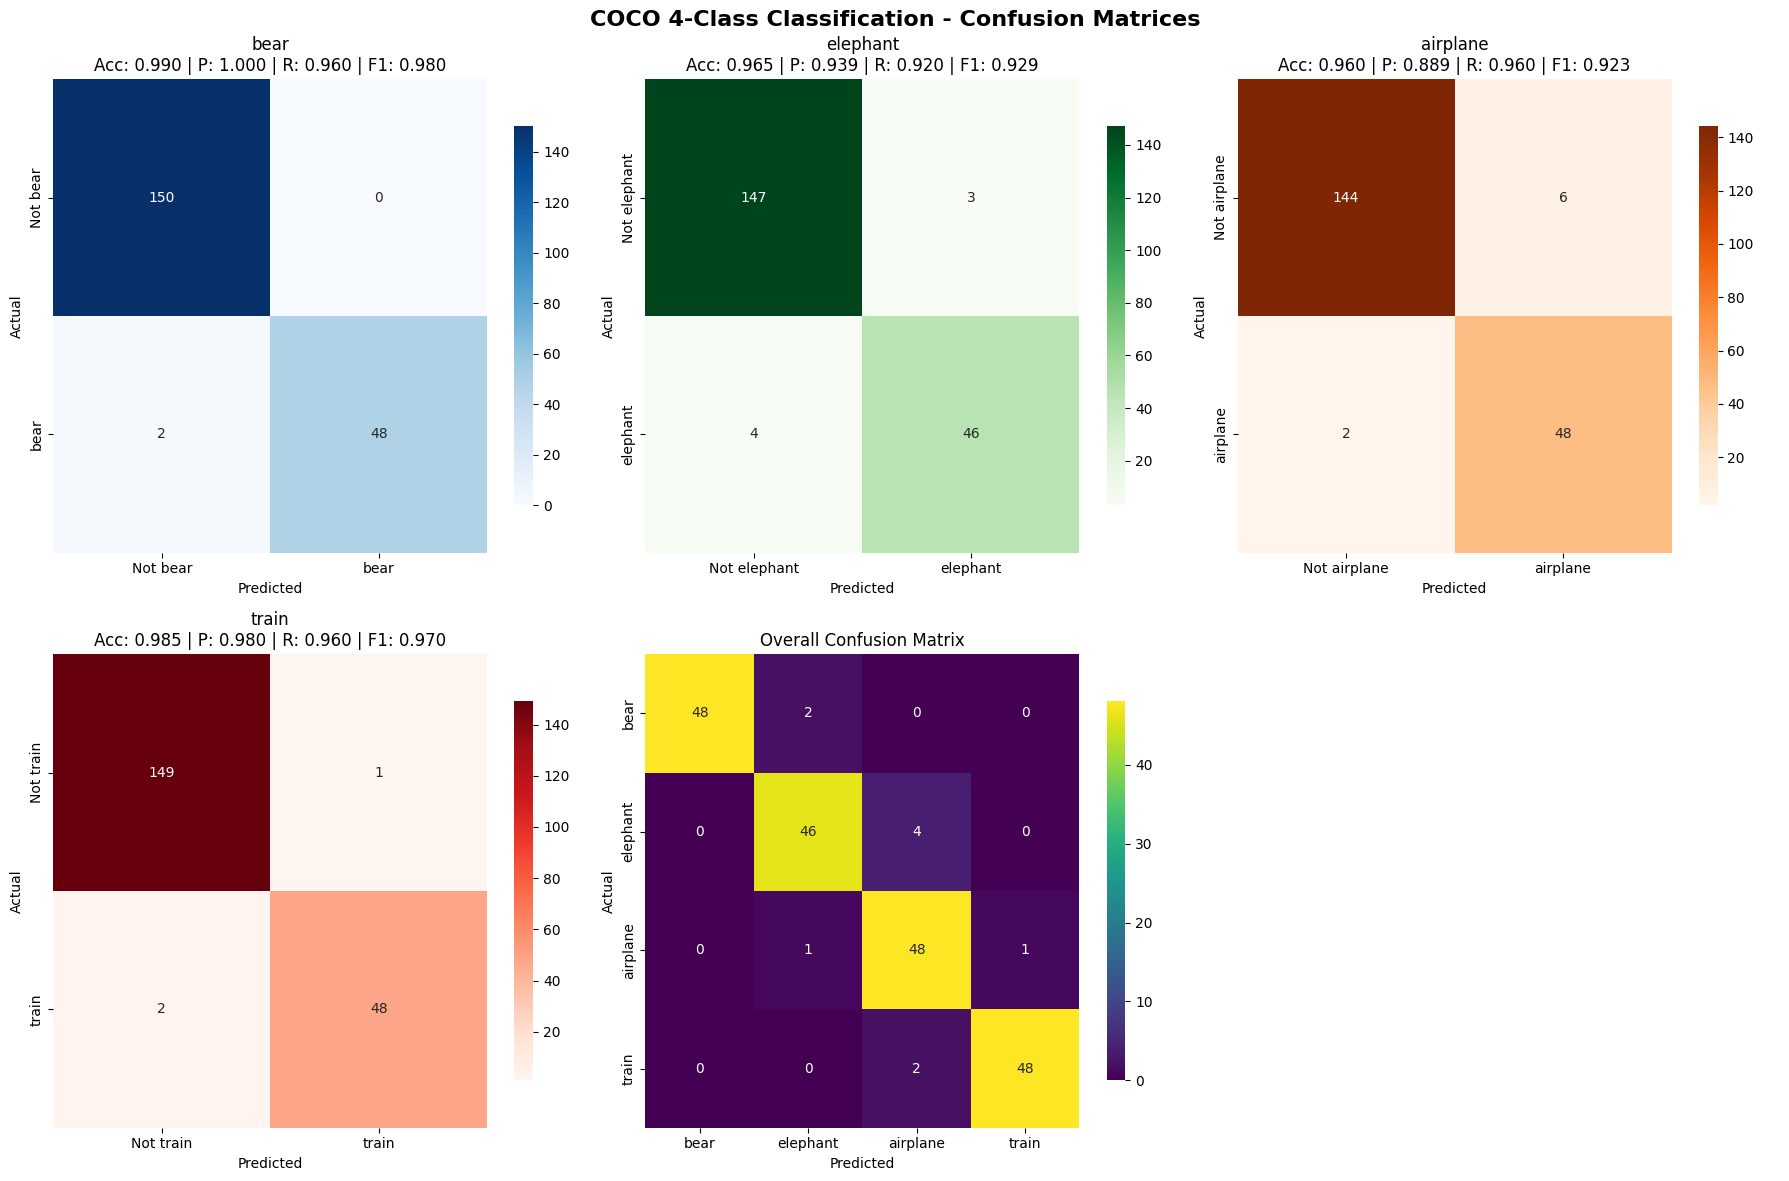


📈 計算詳細評估指標...

🎯 整體準確率: 0.9500 (95.0%)

📋 各類別詳細指標:
--------------------------------------------------------------------------------
類別           精確率        召回率        F1分數       準確率        支持數       
--------------------------------------------------------------------------------
bear         1.000      0.960      0.980      0.990      50        
  ✅ bear 達到95%準確率目標！
elephant     0.939      0.920      0.929      0.965      50        
  ✅ elephant 達到95%準確率目標！
airplane     0.889      0.960      0.923      0.960      50        
  ✅ airplane 達到95%準確率目標！
train        0.980      0.960      0.970      0.985      50        
  ✅ train 達到95%準確率目標！
--------------------------------------------------------------------------------

📊 達到95%準確率的類別數: 4/4
🎉 所有類別都達到了95%準確率目標！

💾 評估結果已保存至: /content/evaluation_results.json

✅ 模型評估完成！


In [22]:
# ==========================================
# Part 7: 模型評估與混淆矩陣
# ==========================================

def evaluate_model(model, data_loader, device, class_names):
    """
    完整的模型評估函數
    計算整體準確率、各類別準確率和混淆矩陣
    """
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    print("正在進行模型評估...")

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='評估中'):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # 前向傳播
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # 收集結果
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 轉換為numpy陣列
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    return all_preds, all_labels, all_probs

def plot_confusion_matrices(y_true, y_pred, class_names):
    """
    繪製每個類別的混淆矩陣和整體混淆矩陣
    """
    print("\n📊 生成混淆矩陣...")

    # 整體混淆矩陣
    overall_cm = confusion_matrix(y_true, y_pred)

    # 設定圖表樣式
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('COCO 4-Class Classification - Confusion Matrices', fontsize=16, fontweight='bold')

    # 顏色映射
    colors = ['Blues', 'Greens', 'Oranges', 'Reds', 'Purples']

    # 繪製每個類別的混淆矩陣
    for i, class_name in enumerate(class_names):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        # 為當前類別創建二元混淆矩陣
        # True Positive, False Negative, False Positive, True Negative
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        binary_cm = confusion_matrix(y_true_binary, y_pred_binary)

        # 繪製熱圖
        sns.heatmap(binary_cm,
                   annot=True,
                   fmt='d',
                   cmap=colors[i],
                   xticklabels=[f'Not {class_name}', f'{class_name}'],
                   yticklabels=[f'Not {class_name}', f'{class_name}'],
                   ax=ax,
                   cbar_kws={'shrink': 0.8})

        # 計算該類別的精確率、召回率和F1分數
        TP = binary_cm[1, 1]
        FN = binary_cm[1, 0]
        FP = binary_cm[0, 1]
        TN = binary_cm[0, 0]

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        ax.set_title(f'{class_name}\nAcc: {accuracy:.3f} | P: {precision:.3f} | R: {recall:.3f} | F1: {f1:.3f}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    # 繪製整體混淆矩陣
    ax_overall = axes[1, 1]
    sns.heatmap(overall_cm,
               annot=True,
               fmt='d',
               cmap='viridis',
               xticklabels=class_names,
               yticklabels=class_names,
               ax=ax_overall,
               cbar_kws={'shrink': 0.8})

    ax_overall.set_title('Overall Confusion Matrix')
    ax_overall.set_xlabel('Predicted')
    ax_overall.set_ylabel('Actual')

    # 隱藏最後一個子圖
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig('/content/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

    return overall_cm

def calculate_detailed_metrics(y_true, y_pred, y_probs, class_names):
    """
    計算詳細的評估指標
    """
    print("\n📈 計算詳細評估指標...")

    # 整體準確率
    overall_accuracy = accuracy_score(y_true, y_pred)

    # 分類報告
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    print(f"\n🎯 整體準確率: {overall_accuracy:.4f} ({overall_accuracy:.1%})")
    print("\n📋 各類別詳細指標:")
    print("-" * 80)
    print(f"{'類別':<12} {'精確率':<10} {'召回率':<10} {'F1分數':<10} {'準確率':<10} {'支持數':<10}")
    print("-" * 80)

    # 計算各類別的準確率
    class_accuracies = []
    for i, class_name in enumerate(class_names):
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        # 計算混淆矩陣元素
        TP = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        TN = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
        FP = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        FN = np.sum((y_true_binary == 1) & (y_pred_binary == 0))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        class_accuracies.append(accuracy)

        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']

        print(f"{class_name:<12} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {accuracy:<10.3f} {support:<10.0f}")

        # 檢查是否達到95%準確率
        if accuracy >= 0.95:
            print(f"  ✅ {class_name} 達到95%準確率目標！")
        else:
            print(f"  ❌ {class_name} 未達到95%準確率目標 (目前: {accuracy:.1%})")

    print("-" * 80)

    # 統計達到95%準確率的類別數
    classes_above_95 = sum(1 for acc in class_accuracies if acc >= 0.95)

    print(f"\n📊 達到95%準確率的類別數: {classes_above_95}/{len(class_names)}")

    if classes_above_95 == len(class_names):
        print("🎉 所有類別都達到了95%準確率目標！")
    else:
        print(f"⚠️  還有 {len(class_names) - classes_above_95} 個類別未達到95%準確率目標")

    return {
        'overall_accuracy': overall_accuracy,
        'class_accuracies': dict(zip(class_names, class_accuracies)),
        'classification_report': report,
        'classes_above_95_percent': classes_above_95
    }

# 執行模型評估
print("開始評估訓練好的模型...")

# 在驗證集上評估
val_preds, val_labels, val_probs = evaluate_model(trained_model, val_loader, device, TARGET_CATEGORIES)

# 繪製混淆矩陣
overall_cm = plot_confusion_matrices(val_labels, val_preds, TARGET_CATEGORIES)

# 計算詳細指標
detailed_metrics = calculate_detailed_metrics(val_labels, val_preds, val_probs, TARGET_CATEGORIES)

# 保存評估結果
evaluation_results = {
    'predictions': val_preds.tolist(),
    'true_labels': val_labels.tolist(),
    'probabilities': val_probs.tolist(),
    'confusion_matrix': overall_cm.tolist(),
    'detailed_metrics': detailed_metrics,
    'class_names': TARGET_CATEGORIES
}

# 保存到文件
import json
with open('/content/evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"\n💾 評估結果已保存至: /content/evaluation_results.json")
print("\n✅ 模型評估完成！")